### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [170]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#     def __find_threshold(self, x, y):
#         """
#         Находим оптимальный признак и порог для сплита
#         Здесь используемые разные impurity в зависимости от self.criterion
#         """
#         max_info_gain = -1
#         if x.shape[0] == 0:
#             raise RuntimeError("Received an empty sample!")

#         features = np.arange(x.shape[1])
#         varians = np.array([])

#         for feature in features:
#             tmp = np.unique(x[:,feature])
#             if tmp.shape[0] < 2:
#                 thresholds = tmp.copy()
#             else:
#                 thresholds = np.mean((tmp[:-1], np.roll(tmp, -1)[:-1]), axis=0)
#             tmp_features = np.repeat(feature, thresholds.shape[0])
#             tmp = np.dstack((tmp_features, thresholds))[0]

#             if varians.shape[0] == 0:
#                 varians = tmp.copy()
#             else:
#                 varians = np.vstack((varians, tmp))
        
#         current_info = self.__info(x, y, self.criterion)
        
#         for f_and_t in varians:
            
#             feature_id = int(f_and_t[0])
#             threshold  = f_and_t[1]
            
#             # print(feature_id, threshold)

#             x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold)
#             left_share = x_left.shape[0] / x.shape[0]

#             left_info  = left_share       * self.__info(x_left,  y_left,  self.criterion)
#             right_info = (1 - left_share) * self.__info(x_right, y_right, self.criterion)

#             info_gain = current_info - left_info - right_info

#             print(feature_id, "%.4f" % threshold, "%.10f" % info_gain, "%.10f" % max_info_gain)
            
#             if info_gain > max_info_gain:

#                 max_info_gain = info_gain
#                 best_feature_id = feature_id
#                 best_threshold  = threshold
                
#             print("best feature: %.f" % best_feature_id, "best th: %.4f" % best_threshold)
#             print()

#         x_left, x_right, y_left, y_right = self.__div_samples(x, y, best_feature_id, best_threshold) # ~о-мально!
#         return best_feature_id, best_threshold, x_left, x_right, y_left, y_right
        


In [1118]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.criterion = criterion
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion

        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
                
        self.tree = {0: [self.__class__.NON_LEAF_TYPE, -1, 0.0]}
        

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    

    def __info(self, x, y, criterion):
        """
        Считаем меру неопределённости
        посредством критерия criterion
        по выборке (x, y)
        """
        
        y_len = y.shape[0]

        if y_len == 0:
            return 0.0
        
        prob_distr = np.bincount(y,\
                                 minlength=self.num_class,\
                                 weights=[1/y_len]*y_len)
        
        if   criterion == 'error':
            return 1 - prob_distr.max()
        
        elif criterion == 'gini':
            return 1 - np.power(prob_distr, 2).sum()
        
        elif criterion == 'entropy':
            return -(prob_distr * np.log2(prob_distr+1e-10)).sum() # 2 - в битах (e - натах).
        
        else:
            return 0.1
            # raise RuntimeError("No such criterion as \'{}\'!".format(criterion))
            
    
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        max_info_gain = -1
        if x.shape[0] == 0:
            raise RuntimeError("Received an empty sample!")
            
        for feature_id in range(x.shape[1]): # Использовать np.apply_along_axis()
            
            current_info = self.__info(x, y, self.criterion)
            
            tmp = np.unique(x[:,feature_id])
            if tmp.shape[0] < 2:
                thresholds = tmp
            else:
                thresholds = np.mean((tmp[:-1], np.roll(tmp, -1)[:-1]), axis=0)
            
            for threshold in thresholds: # Испо-ать np.apply_along_axis()
                
                x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold)
                left_share = x_left.shape[0] / x.shape[0]
                
                left_info  = left_share       * self.__info(x_left,  y_left,  self.criterion)
                right_info = (1 - left_share) * self.__info(x_right, y_right, self.criterion)
                
                info_gain = current_info - left_info - right_info
                
                if info_gain > max_info_gain:
                    
                    max_info_gain = info_gain
                    best_feature_id = feature_id
                    best_threshold  = threshold
            
        
        x_left, x_right, y_left, y_right = self.__div_samples(x, y, best_feature_id, best_threshold) # ~о-мально!
        return best_feature_id, best_threshold, x_left, x_right, y_left, y_right
        

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # if trunc(np.log2(node_id+1)) > depth:
        #      return
    
        c_node = self.tree[node_id]
        
        y_len = y.shape[0]
        prob_distr = np.bincount(y, minlength=self.num_class,\
                                    weights=[1/y_len]*y_len)
        
        condition = (x.shape[0] <= self.min_samples_split) or (np.isclose(np.max(prob_distr), 1.0))   
        
        if condition:
            c_node[0] = self.__class__.LEAF_TYPE        
            c_node[1] = np.argmax(prob_distr)
            c_node[2] = prob_distr[c_node[1]]
        
        else:
            c_node[1], c_node[2], x_left, x_right, y_left, y_right = self.__find_threshold(x, y)
            c_node[0] = self.__class__.NON_LEAF_TYPE
            self.tree[2*node_id+1] = [None, None, None]
            self.tree[2*node_id+2] = [None, None, None]  
            self.__fit_node(x_left,  y_left,  2*node_id+1, depth+1)
            self.__fit_node(x_right, y_right, 2*node_id+2, depth+1)
    
    
    def fit(self, x, y):        
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(np.asarray(x), np.asarray(y), 0, 0)
            

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in np.asarray(X)])

    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

    
    def get_feature_importance():
        """
        Возвращает важность признаков
        """
        # Ваш код здесь
        pass

In [1129]:
a = np.array([1,2,3])
b = np.array([10,20])
tmp1 = np.repeat(a, b.shape[0])
tmp2 = np.tile(b, a.shape[0])
np.dstack((tmp1,tmp2))[0]

array([[ 1, 10],
       [ 1, 20],
       [ 2, 10],
       [ 2, 20],
       [ 3, 10],
       [ 3, 20]])

In [1130]:
%timeit np.unique(x[:,5])

20.4 µs ± 3.84 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [1120]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='fuck ya')
clf = DecisionTreeClassifier(min_samples_split=2, criterion='gini')

In [1121]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [1122]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [1123]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

(0.8888888888888888, 0.6666666666666666)

In [1124]:
from IPython.display import Image  
from sklearn import tree
import pydotplus # installing pyparsing maybe needed

dot_data = tree.export_graphviz(clf, out_file=None, feature_names = None)
graph = pydotplus.graph_from_dot_data(dot_data)
#Image(graph.create_png())

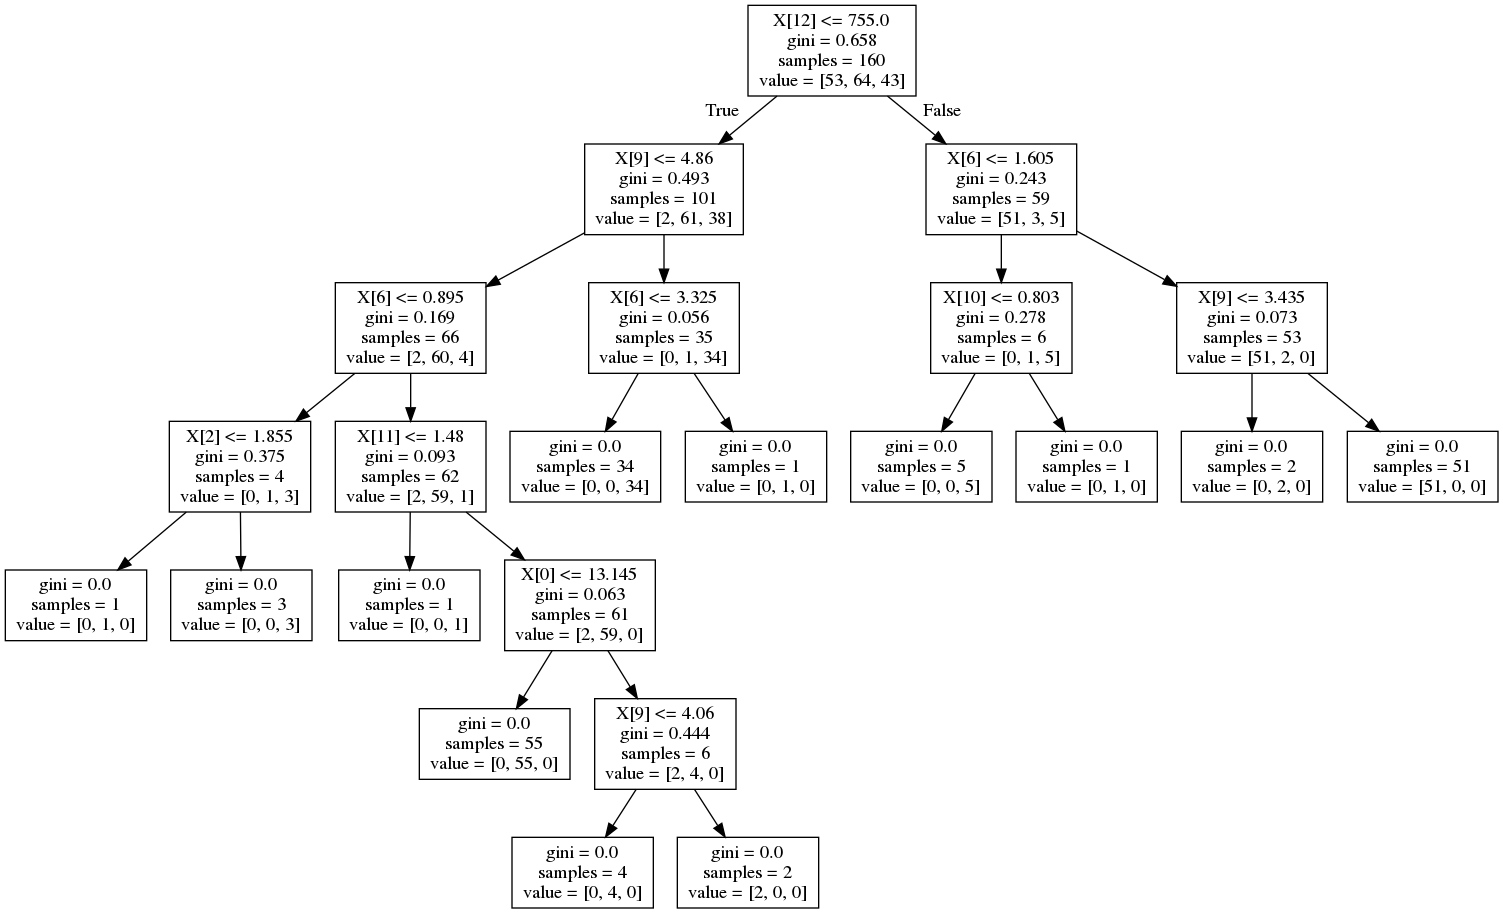

In [1125]:
Image(graph.create_png())

In [1126]:
my_clf.tree

{0: [0, 0, 13.515],
 1: [0, 0, 13.864999999999998],
 2: [0, 1, 3.58],
 3: [0, 1, 1.935],
 4: [0, 0, 13.765],
 7: [0, 0, 14.145],
 8: [0, 0, 13.89],
 15: [0, 0, 14.215],
 16: [0, 0, 14.08],
 31: [1, 0, 1.0],
 32: [1, 0, 0.5],
 33: [1, 0, 0.5],
 34: [1, 0, 1.0],
 17: [0, 0, 13.92],
 18: [1, 0, 1.0],
 35: [0, 0, 14.225000000000001],
 36: [1, 0, 1.0],
 71: [0, 0, 14.32],
 72: [1, 0, 0.9999999999999998],
 143: [0, 0, 14.36],
 144: [1, 0, 1.0],
 287: [1, 0, 1.0],
 288: [1, 2, 1.0],
 9: [0, 0, 13.825],
 10: [0, 0, 13.54],
 19: [0, 0, 13.835],
 20: [0, 0, 13.774999999999999],
 39: [0, 0, 13.85],
 40: [1, 0, 1.0],
 79: [1, 0, 0.5],
 80: [1, 2, 1.0],
 41: [1, 0, 0.5],
 42: [1, 0, 1.0],
 21: [0, 1, 1.375],
 22: [1, 2, 1.0],
 43: [0, 0, 13.57],
 44: [1, 1, 1.0],
 87: [0, 1, 1.5150000000000001],
 88: [1, 0, 1.0],
 175: [0, 1, 2.84],
 176: [1, 0, 1.0],
 351: [0, 0, 13.665],
 352: [0, 0, 13.725000000000001],
 703: [1, 2, 1.0],
 704: [1, 0, 0.5],
 705: [1, 0, 1.0],
 706: [0, 0, 13.629999999999999],
 1

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [1127]:
%timeit clf.fit(X_train, y_train)

1.56 ms ± 80.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [1128]:
%timeit my_clf.fit(X_train, y_train)

677 ms ± 9.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

